<a href="https://colab.research.google.com/github/lazarogibert/Tesis/blob/main/Neural_network_BMT_keras_weighted_loss_function_v4_29_test20_early_stopping_functional_api_all_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 10.6 MB/s eta 0:00:00


In [3]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.3/221.3 kB 6.7 MB/s eta 0:00:00


In [4]:
!pip install rank_metrics

ERROR: Could not find a version that satisfies the requirement rank_metrics (from versions: none)
ERROR: No matching distribution found for rank_metrics


In [5]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 13.4 MB/s eta 0:00:00


In [6]:
!pip install focal-loss

In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.compose import make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Pre-procesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from feature_engine.imputation import RandomSampleImputer
import seaborn as sns
# Metricas de evaluación
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
import multiprocessing
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import ndcg_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer
from skorch import NeuralNetBinaryClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn.functional as F
from focal_loss import BinaryFocalLoss
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping


#Getting the datset

In [8]:
data = arff.loadarff(open('/content/sample_data/bone-marrow.arff', encoding="utf-8"))
df = pd.DataFrame(data[0])
# code to fix the problem with encoding of the file
tmp_df = df.select_dtypes([object])
tmp_df = tmp_df.stack().str.decode("utf-8").unstack()
for col in tmp_df:
    df[col] = tmp_df[col]
df =df.replace({'?': None})
df.head()


,donor_age,donor_age_below_35,donor_ABO,donor_CMV,recipient_age,recipient_age_below_10,recipient_age_int,recipient_gender,recipient_body_mass,recipient_ABO,...,CD3_to_CD34_ratio,ANC_recovery,PLT_recovery,acute_GvHD_II_III_IV,acute_GvHD_III_IV,time_to_acute_GvHD_III_IV,extensive_chronic_GvHD,relapse,survival_time,survival_status
0,22.830137,yes,A,present,9.6,yes,5_10,male,35.0,A,...,1.338760,19.0,51.0,yes,yes,32.0,no,no,999.0,0
1,23.342466,yes,B,absent,4.0,yes,0_5,male,20.6,B,...,11.078295,16.0,37.0,yes,no,1000000.0,no,yes,163.0,1
2,26.394521,yes,B,absent,6.6,yes,5_10,male,23.4,B,...,19.013230,23.0,20.0,yes,no,1000000.0,no,yes,435.0,1
3,39.684932,no,A,present,18.1,no,10_20,female,50.0,AB,...,29.481647,23.0,29.0,yes,yes,19.0,None,no,53.0,1
4,33.358904,yes,A,absent,1.3,yes,0_5,female,9.0,AB,...,3.972255,14.0,14.0,no,no,1000000.0,no,no,2043.0,0


In [9]:
cleanup_nums = {"acute_GvHD_II_III_IV": {"yes":1, "no":0}}
df =df.replace(cleanup_nums)
df.acute_GvHD_II_III_IV=df.acute_GvHD_II_III_IV.astype('int')

#Selecting Features and deleting nulls

In [10]:
df=df.loc[:,['recipient_age','donor_ABO','donor_CMV','recipient_gender','recipient_ABO','recipient_rh','recipient_CMV','disease','disease_group','HLA_mismatch','stem_cell_source','CD34_x1e6_per_kg','acute_GvHD_II_III_IV']]

In [11]:
df=df.dropna()
df.shape

(171, 13)

In [12]:
#df = df.loc[df['disease']!='lymphoma']

## Final Distribution of the classes

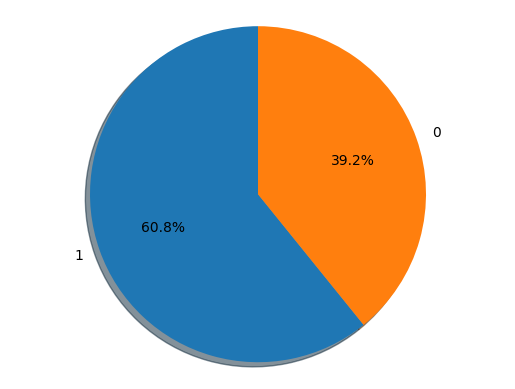

In [13]:
#Decision class distribution
groups = df['acute_GvHD_II_III_IV'].value_counts()
sizes = [groups[1], groups[0]]
labels = list(map(lambda e: str(e), groups.index))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

In [14]:
print(groups)

1    104
0     67
Name: acute_GvHD_II_III_IV, dtype: int64


#Preproces the datasets

In [15]:
obj_cols=df.select_dtypes(include=['object']).columns.to_list()

In [16]:
df[obj_cols]=df[obj_cols].astype('category')

In [17]:
cat_cols=df.select_dtypes(include=['category']).columns.to_list()

In [18]:
X=df.drop(['acute_GvHD_II_III_IV'],axis=1)
y=df.acute_GvHD_II_III_IV

In [19]:
numeric_cols=X.select_dtypes(include=['float64', 'int']).columns.to_list()

In [20]:
transformer = make_column_transformer(
    (OneHotEncoder(), cat_cols),
    remainder='passthrough',
    verbose_feature_names_out=False)

transformed = transformer.fit_transform(X)
#temp=transformed.to_numpy()
#transformed=transformed.toarray()
#print(transformed)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [21]:
transformed_df.head()

,donor_ABO_0,donor_ABO_A,donor_ABO_AB,donor_ABO_B,donor_CMV_absent,donor_CMV_present,recipient_gender_female,recipient_gender_male,recipient_ABO_0,recipient_ABO_A,...,disease_lymphoma,disease_nonmalignant,disease_group_malignant,disease_group_nonmalignant,HLA_mismatch_matched,HLA_mismatch_mismatched,stem_cell_source_bone_marrow,stem_cell_source_peripheral_blood,recipient_age,CD34_x1e6_per_kg
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,9.6,7.20
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,4.0,4.50
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,6.6,7.94
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,18.1,4.25
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.3,51.85


In [22]:
X=transformed_df

#Neural network

##Neural network implemetation

In [23]:
!pip install scikeras

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import class_weight
import tensorflow
from tensorflow.keras.layers import Input
from tensorflow.keras import layers

In [25]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y),
                                                 y=y)

In [26]:
print(class_weights)

[1.2761194  0.82211538]


In [36]:
X_train=X
y_train=y

In [37]:
# Define the neural network model
def create_model(hidden_layers=1, units=64, activation='relu', learning_rate=0.001):
    inputs = keras.Input(shape=(X_train.shape[1],))
    dense = layers.Dense(units, activation=activation)
    x = dense(inputs)
    #model.add(Dense(units, input_dim=X_train.shape[1], activation=activation))
    for _ in range(hidden_layers - 1):
        x = layers.Dense(units, activation=activation)(x)

        #model.add(Dense(units, activation=activation))
    outputs=(layers.Dense(1, activation='sigmoid'))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [38]:
class_weights2 = {0: 1.89,
                1: 0.82
                }

# Hyperparameter tunning

In [39]:
from scikeras.wrappers import KerasClassifier
keras_model=KerasClassifier(model=create_model,verbose=0,units=64,learning_rate=0.001,hidden_layers=3,activation='relu',random_state=0,callbacks=tensorflow.keras.callbacks.EarlyStopping(monitor="loss",verbose=1,patience=15))

In [40]:
# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
#pipe = Pipeline([
 #                ('modelo', keras_model)])

modelo=keras_model
param_distributions = {
    #'modelo__hiden_size': [16,32, 64, 128, 256],
    #'modelo__criterion':[torch.nn.BCEWithLogitsLoss,torch.nn.L1Loss,torch.nn.CrossEntropyLoss, torch.nn.BCELoss],
    #'modelo__
    'hidden_layers': [1, 2, 3,4,5,6,7],
    #'modelo__
    'units': [8, 16, 32,64,128],
    #'modelo__
    'activation': ['relu', 'sigmoid'],
    #'modelo__
    'learning_rate': [0.001, 0.01, 0.1],
     #'modelo__
     'epochs':[10,20,30,40,50,100,150,200,250,300]
    #'modelo__optimizer':[torch.optim.Adam,torch.optim.Adadelta,torch.optim.Adamax,torch.optim.Rprop]
    #'modelo__n_layers':[2,3,4,5,6,7,8,9,10]
}

# Búsqueda random grid
fbetascore=make_scorer(fbeta_score, beta=1)
grid = RandomizedSearchCV(
        estimator  = modelo,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = fbetascore,
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X =X, y=y,class_weight=class_weights2)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

Epoch 20: early stopping
Epoch 22: early stopping
Epoch 23: early stopping
Epoch 20: early stopping
Epoch 30: early stopping
Epoch 19: early stopping
Epoch 24: early stopping
Epoch 27: early stopping
Epoch 26: early stopping
Epoch 44: early stopping
Epoch 37: early stopping
Epoch 57: early stopping
Epoch 20: early stopping
Epoch 22: early stopping
Epoch 32: early stopping
Epoch 23: early stopping
Epoch 20: early stopping
Epoch 30: early stopping
Epoch 46: early stopping
Epoch 19: early stopping
Epoch 24: early stopping
Epoch 42: early stopping
Epoch 27: early stopping
Epoch 26: early stopping
Epoch 114: early stopping
Epoch 149: early stopping
Epoch 140: early stopping
Epoch 23: early stopping
Epoch 99: early stopping
Epoch 91: early stopping
Epoch 96: early stopping
Epoch 19: early stopping
Epoch 18: early stopping
Epoch 147: early stopping
Epoch 77: early stopping
Epoch 44: early stopping
Epoch 19: early stopping
Epoch 24: early stopping
Epoch 21: early stopping
Epoch 22: early stopp

,param_units,param_learning_rate,param_hidden_layers,param_epochs,param_activation,mean_test_score,std_test_score,mean_train_score,std_train_score
18,64,0.01,1,100,sigmoid,0.631306,0.078509,0.965296,0.018422


In [41]:
modelo_final = grid.best_estimator_


In [42]:
y_pred = modelo_final.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        67
           1       1.00      0.91      0.95       104

    accuracy                           0.95       171
   macro avg       0.94      0.96      0.95       171
weighted avg       0.95      0.95      0.95       171



In [ ]:
#modelo_final=modelo_final(random_state=0,callbacks=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1,patience=15))

In [43]:
modelo_final=modelo_final.fit(X,y,epochs=100)

In [44]:
#pred_old = modelo_final.predict(X_test)
modelo_final.model_.save("/content/drive/MyDrive/Proyecto de Tesis Lazaro Gibert/BMT29vfunctional-all-dataset")  # saves just the Keras model